# Setup

In [1]:
!pip install kaskada

In [1]:
from datetime import timedelta
import kaskada as kd
import pandas as pd
import pyarrow as pa

In [2]:
kd.init_session()

In [3]:
transfers = kd.sources.Parquet(
  path = "transfers.parquet",
  time_column = "BlockTimestamp",
  key_column = "TokenAddress",
)
transfers.preview(5)

,_time,_key,BlockTimestamp,TokenAddress,TokenID,FromAddress,ToAddress,Price,Quantity
0,2023-06-30 09:44:35,0xdbc13fa2263212210b7b7d36e7d2763e69e4c4f2,2023-06-30 09:44:35,0xdbc13fa2263212210b7b7d36e7d2763e69e4c4f2,18,0x0dacb47e00aed6abade32c7b398e029393e0d848,0x8a3b85128d75b51383855e900c3a8182adc84deb,0.0,1
1,2023-06-30 09:44:35,0xdbc13fa2263212210b7b7d36e7d2763e69e4c4f2,2023-06-30 09:44:35,0xdbc13fa2263212210b7b7d36e7d2763e69e4c4f2,18,0x0dacb47e00aed6abade32c7b398e029393e0d848,0x7f3454fe843455fb7d0ac071d0177c2a6554efee,0.0,1
2,2023-06-30 09:44:35,0xdbc13fa2263212210b7b7d36e7d2763e69e4c4f2,2023-06-30 09:44:35,0xdbc13fa2263212210b7b7d36e7d2763e69e4c4f2,18,0x0dacb47e00aed6abade32c7b398e029393e0d848,0x666e1a01abe04e91963e5d41382115cdc84ec643,0.0,1
3,2023-06-30 09:44:35,0xdbc13fa2263212210b7b7d36e7d2763e69e4c4f2,2023-06-30 09:44:35,0xdbc13fa2263212210b7b7d36e7d2763e69e4c4f2,18,0x0dacb47e00aed6abade32c7b398e029393e0d848,0xbabe2a0486aeceb3ffa4957f5cfdc85763130140,0.0,1
4,2023-06-30 09:44:35,0xdbc13fa2263212210b7b7d36e7d2763e69e4c4f2,2023-06-30 09:44:35,0xdbc13fa2263212210b7b7d36e7d2763e69e4c4f2,18,0x0dacb47e00aed6abade32c7b398e029393e0d848,0x1b0cf9fe79c9298b2364ad1f4d9c085a4974970c,0.0,1


# Feature Engineering

Try building some features

* Target value - the price of each transfer
* Limit to just the transfers you care about - where the sender is empty ("0x0000000000000000000000000000000000000000")
* Add a simple feature - the average price of NFT's in the same group
* Limit that to recent prices
* See if the quantity matters
* The buyer's behavior may matter - pull in the average price paid by the buyer (the to-address)

In [28]:
# The average price paid by a given address
mean_buyer_price = transfers.col("Price").with_key(transfers.col("ToAddress")).mean()

features = kd.record({
    # What the buyer of this token generally pays for NFT's.
    "mbp": mean_buyer_price.lookup(transfers.col("ToAddress")),
    
    # Thast price paid for NFT's in the same group (ie all bored apes)
    "last_transfer": transfers.col("Price").lag(1).else_(0),
    
    # The average price paid for the 10 most recenet NFT's in the same group
   "avg_price": transfers.col("Price").mean(window=kd.windows.Sliding(10, transfers.is_not_null())),
    
    # The average transaction value for NFT's in the same group
    "avg_purchase": transfers.col("Price").mul(transfers.col("Quantity").cast(pa.int32())).mean().else_(0),
})

examples = (
    features
    .extend({
        # The amount paid for each transfer
        "target": transfers.col("Price").last()
    })
    .filter(transfers.col("FromAddress").eq("0x0000000000000000000000000000000000000000"))
)

#examples.filter(transfers.col("TokenAddress").eq("0x14e436971acf3f2b8f6cac82a1e95b1476821f10")).preview(20)
examples.preview(20)

,_time,_key,target,mbp,last_transfer,avg_price,avg_purchase
0,2023-06-30 09:44:47,0xecf79dc580fbc8e322f060465fb4227af64e8cfc,0.000,0.000,0.000,0.000,0.000
1,2023-06-30 09:44:47,0x68b9c676b21e24b7bda336fc048021339bbb3382,0.000,0.000,0.000,0.000,0.000
2,2023-06-30 09:44:47,0x4f5faf713f1a37d4d1fbb73206285d27eca55816,0.000,0.000,0.000,0.000,0.000
3,2023-06-30 09:44:47,0x4f5faf713f1a37d4d1fbb73206285d27eca55816,0.000,0.000,0.000,0.000,0.000
4,2023-06-30 09:44:47,0x4f5faf713f1a37d4d1fbb73206285d27eca55816,0.000,0.000,0.000,0.000,0.000
5,2023-06-30 09:44:47,0x4f5faf713f1a37d4d1fbb73206285d27eca55816,0.000,0.000,0.000,0.000,0.000
6,2023-06-30 09:44:47,0x4f5faf713f1a37d4d1fbb73206285d27eca55816,0.000,0.000,0.000,0.000,0.000
7,2023-06-30 09:44:47,0x4f5faf713f1a37d4d1fbb73206285d27eca55816,0.000,0.000,0.000,0.000,0.000
8,2023-06-30 09:44:47,0x4f5faf713f1a37d4d1fbb73206285d27eca55816,0.000,0.000,0.000,0.000,0.000
9,2023-06-30 09:44:47,0x4f5faf713f1a37d4d1fbb73206285d27eca55816,0.000,0.000,0.000,0.000,0.000


Root Mean Squared Error (RMSE): 4.15938532137875
             mbp  last_transfer  avg_price  avg_purchase
337581  0.005692       0.000000   0.000000  0.000000e+00
382472  0.000000       0.000000   0.000000  0.000000e+00
531546  0.000000       0.000000   0.000000  1.174609e-07
44402   0.003450       0.003450   0.003450  3.361915e-03
570746  0.020700       0.020700   0.020700  6.952372e-03
...          ...            ...        ...           ...
386214  0.000000       0.000000   0.000000  2.853093e-02
509752  0.000114       0.000000   0.000000  1.231791e-07
243509  0.039960       0.066600   0.038961  5.333741e-02
518824  0.002669       0.002732   0.014751  1.366197e-02
103599  0.010000       0.020000   0.018000  2.678122e-02

[10000 rows x 4 columns]


(0.0, 18.0)

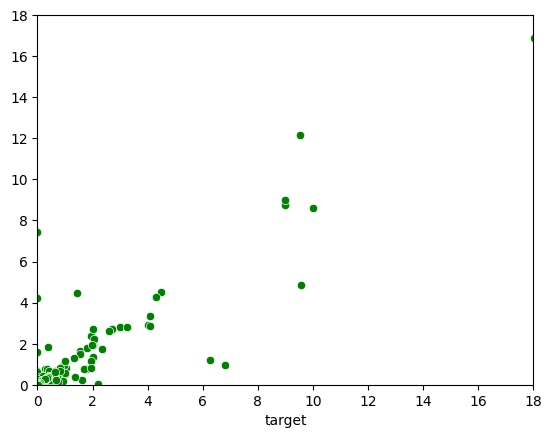

In [29]:
import seaborn as sns
import numpy as np
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import sklearn.ensemble as se
import pickle


# Split input DF into features and labels so we can easily pass to test_train_split for housekeeping
examples_df = examples.to_pandas()
X = examples_df.drop(["target", "_key", "_time"], axis=1)
y = examples_df.target

# model training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000, train_size=50000, random_state=1205)
rf = se.RandomForestRegressor(n_estimators=100, random_state=1205)
rf.fit(X_train, y_train)

# model performance eval
y_pred = rf.predict(X_test)

print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print(X_test)

g = sns.scatterplot(x=y_test , y=y_pred, color="green")
g.set_xlim(0, 18)

g.set_ylim(0, 18)

# Inference